In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [151]:
# Read csv file
df = pd.read_csv("cleaned_data.csv")  
df = df.drop(columns=["url", "id"]) # drop columns url, id
df = df.drop(columns=["MunicipalityCleanName", "locality"]) # same variable as post code
# Convert 'postCode' to string
df['postCode'] = df['postCode'].astype(str)
df.head()

,type,subtype,bedroomCount,province,postCode,habitableSurface,buildingCondition,hasGarden,gardenSurface,hasTerrace,epcScore,price,hasParking,region,price_square_meter
0,APARTMENT,APARTMENT,2.0,Brussels,1040,100.0,GOOD,0,0.0,1,C,399000.0,1,Brussels,3990.000000
1,HOUSE,HOUSE,4.0,Brussels,1040,270.0,TO_BE_DONE_UP,1,100.0,1,E,895000.0,0,Brussels,3314.814815
2,APARTMENT,APARTMENT,2.0,Brussels,1040,87.0,AS_NEW,0,0.0,1,F,465000.0,0,Brussels,5344.827586
3,APARTMENT,APARTMENT,2.0,Brussels,1040,104.0,AS_NEW,0,0.0,1,B,590000.0,0,Brussels,5673.076923
4,APARTMENT,FLAT_STUDIO,1.0,Brussels,1040,71.0,AS_NEW,0,0.0,0,E,289000.0,0,Brussels,4070.422535


In [152]:
# copy the original dataFrame to evoid overwritting
df_clean = df.copy()

# Identify unique numerical columns
numeric_cols = df_clean.select_dtypes(include=["float64", "int64"]).columns

# Delete outliers in each numerical column
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

# Display the form of cleaning DataFrame
print(f"Remaining observations : {df_clean.shape[0]} (on {df.shape[0]})")

Remaining observations : 27770 (on 41726)


In [153]:
# rename the dataFrame
df = df_clean

In [154]:
# convert feature epcScore and buildingConstruction to numerical
epc_score = {"A++": 9,
             "A+": 8,
             "A": 7,
             "B": 6,
             "C": 5,
             "D": 4,
             "E": 3,
             "F": 2,
             "G": 1}
df["epc_score"] = df["epcScore"].map(epc_score)

building_condition = {"AS_NEW": 6,
                      "GOOD": 5,
                      "JUST_RENOVATED": 4,
                      "TO_BE_DONE_UP": 3,
                      "TO_RENOVATE": 2,
                      "TO_RESTORE": 1}
df["building_condition"] = df["buildingCondition"].map(building_condition)


In [155]:
# list of nominal variable

cat_features = ['type', 'subtype', 'province', 'region']

# ColumnTransformer with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough'  # others numerical columns still unchange
)

In [ ]:

# Complet Pipeline for linear regression
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regression', LinearRegression())
])

y = df["price"]
# drop buildingCondition and epcScore after convertion 
X = df.drop(columns=["price", 'postCode', "buildingCondition", "price_square_meter", "epcScore"])
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# Training of the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Display prediction
#print("Prédictions :", y_pred)

r2 = r2_score(y_test, y_pred)
#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("R² :", r2)
print("MAE :", mae)

#print("RMSE :", rmse)

Index(['type', 'subtype', 'bedroomCount', 'province', 'habitableSurface',
       'hasGarden', 'gardenSurface', 'hasTerrace', 'hasParking', 'region',
       'epc_score', 'building_condition'],
      dtype='object')
R² : 0.5746539218400482
📏 MAE : 64528.68006831417


In [158]:
# Pipeline with Random Forest
model_rf = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regression', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Training of the model
model_rf.fit(X_train, y_train)

# Predictions
y_pred_rf = model_rf.predict(X_test)

# Simple assessment
from sklearn.metrics import mean_squared_error, r2_score


#mse = mean_squared_error(y_test, y_pred_rf)
#rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

mae = mean_absolute_error(y_test, y_pred_rf)

print("R² of Random Forest model :", r2)
print("MAE of Random Forest model :", mae)
#print("RMSE of  Random Forest model :", rmse)

R² of Random Forest model : 0.6087755164091287
MAE of Random Forest model : 60585.07119585265


In [159]:
# comparison between prediction and real value
comparison = pd.DataFrame({
    "Real Values": y_test.values,
    "Prediction": y_pred
})
#print(comparison.head(10))

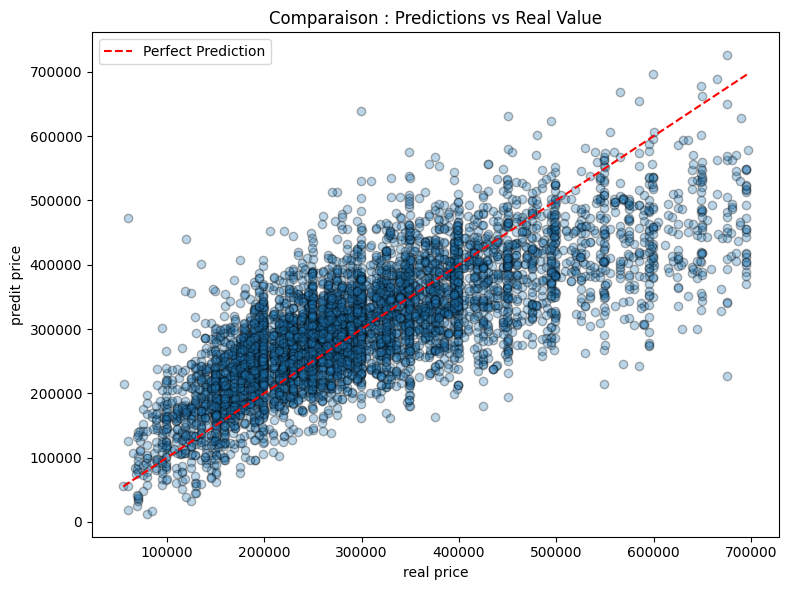

In [160]:
# scatterplot of the comparison
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("real price")
plt.ylabel("predit price")
plt.title("Comparaison : Predictions vs Real Value")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# search of anomalie
df_resultats = pd.DataFrame({
    "real_price": y_test,
    "predit_price": y_pred,
})
df_resultats["error"] = df_resultats["real_price"] - df_resultats["predit_price"]
df_resultats["absolute_error"] = df_resultats["error"].abs()


In [131]:
anomalies = df_resultats.sort_values(by="absolute_error", ascending=False).head(10)
print(anomalies)


       real_price   predit_price          error  absolute_error
34263    975000.0  301937.074258  673062.925742   673062.925742
20757    950000.0  283030.392296  666969.607704   666969.607704
34343    949000.0  298580.600460  650419.399540   650419.399540
35520    995000.0  350013.149108  644986.850892   644986.850892
9025     960000.0  315723.270484  644276.729516   644276.729516
7578     960000.0  315723.270484  644276.729516   644276.729516
34687    975000.0  334520.113983  640479.886017   640479.886017
32132    950000.0  309986.903701  640013.096299   640013.096299
34496    975000.0  339693.634169  635306.365831   635306.365831
34641    955000.0  322192.504410  632807.495590   632807.495590


In [132]:
# Join with X_test to see caracteristics 
anomalies = anomalies.join(X_test, how="left")

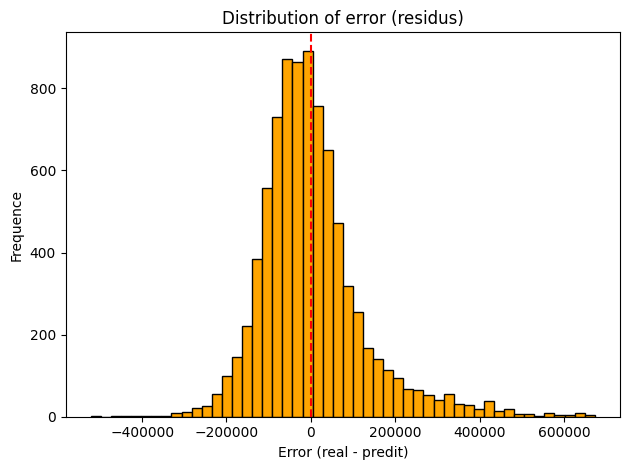

In [ ]:
# histogramm of error distribution
plt.hist(df_resultats["error"], bins=50, color="orange", edgecolor="black")
plt.title("Distribution of error (residus)")
plt.xlabel("Error (real - predit)")
plt.ylabel("Frequency")
plt.axvline(0, color="red", linestyle="--")
plt.tight_layout()
plt.show()

In [ ]:
# Pipeline polynomial with degre 2
poly_model = make_pipeline(
    preprocessor,  # existing encoding
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

# Training
poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

# Assessment
r2_poly = r2_score(y_test, y_pred_poly)
# rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
mae = mean_absolute_error(y_test, y_pred_poly)

print("R² of polynomial model :", r2_poly)
print("MAE of polynomial model :", mae)
#print("RMSE (polynomial) :", rmse_poly)

R² (polynomial) : 0.6224726874551113
MAE of polynomial model : 60689.02304957033


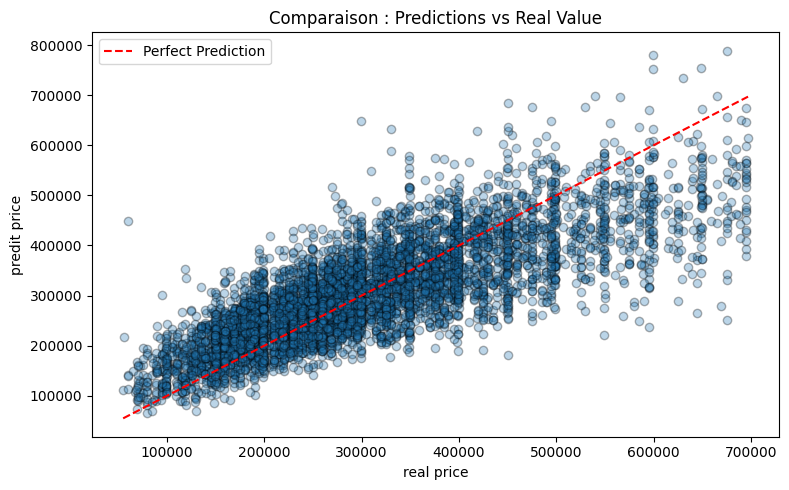

In [166]:
# comparison between prediction and real value
comparison = pd.DataFrame({
    "Real Values": y_test.values,
    "Prediction": y_pred_poly
})

# scatterplot of the comparison
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_poly, alpha=0.3, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("real price")
plt.ylabel("predit price")
plt.title("Comparaison : Predictions vs Real Value")
plt.legend()
plt.tight_layout()
plt.show()

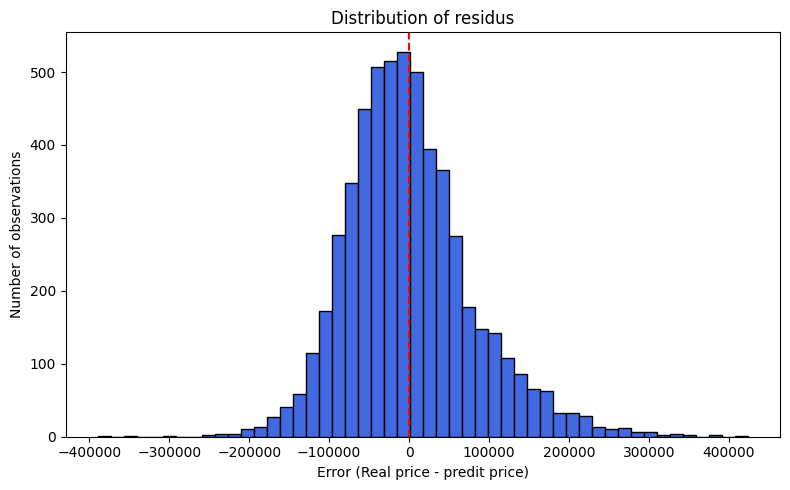

In [167]:
# Distribution of residus in polynomial model
residus = y_test - y_pred_poly

plt.figure(figsize=(8, 5))
plt.hist(residus, bins=50, color='royalblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of residus")
plt.xlabel("Error (Real price - predit price)")
plt.ylabel("Number of observations")
plt.tight_layout()
plt.show()

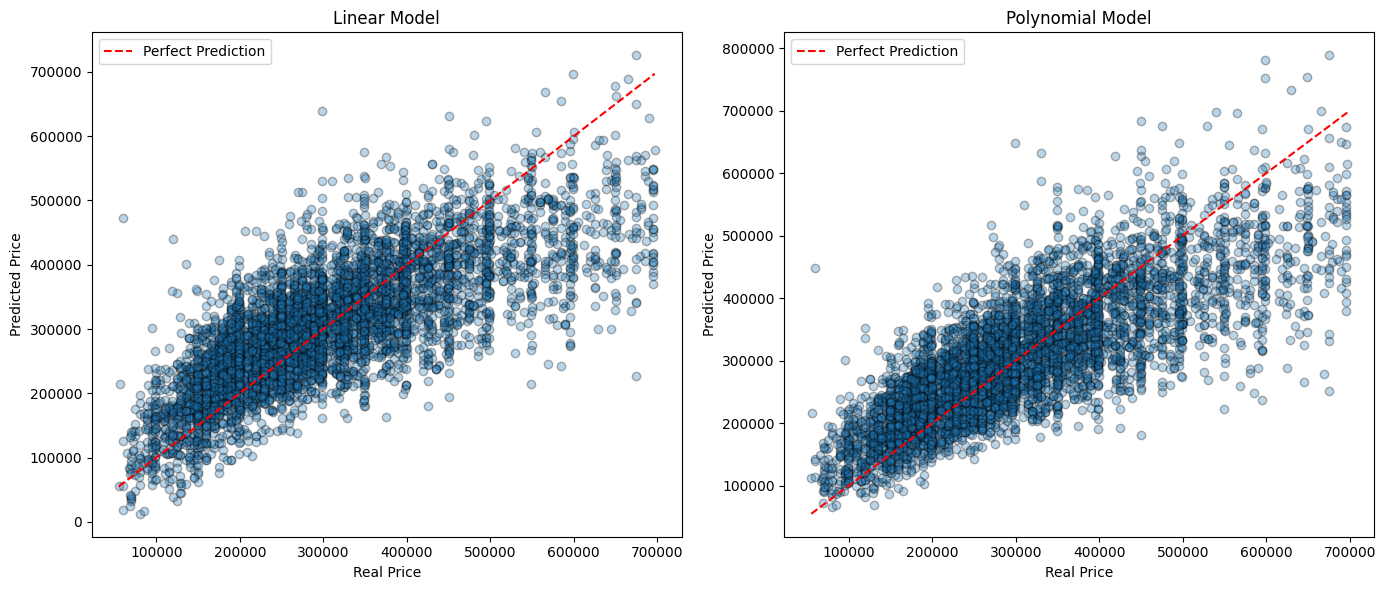

In [168]:
# Initialization of two side-by-side subplots

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1st graph — Linear Model
axes[0].scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', label='Perfect Prediction')
axes[0].set_xlabel("Real Price")
axes[0].set_ylabel("Predicted Price")
axes[0].set_title("Linear Model")
axes[0].legend()

# 2nd graph — Polynomial Model
axes[1].scatter(y_test, y_pred_poly, alpha=0.3, edgecolors='k')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', label='Perfect Prediction')
axes[1].set_xlabel("Real Price")
axes[1].set_ylabel("Predicted Price")
axes[1].set_title("Polynomial Model")
axes[1].legend()

plt.tight_layout()
plt.show()

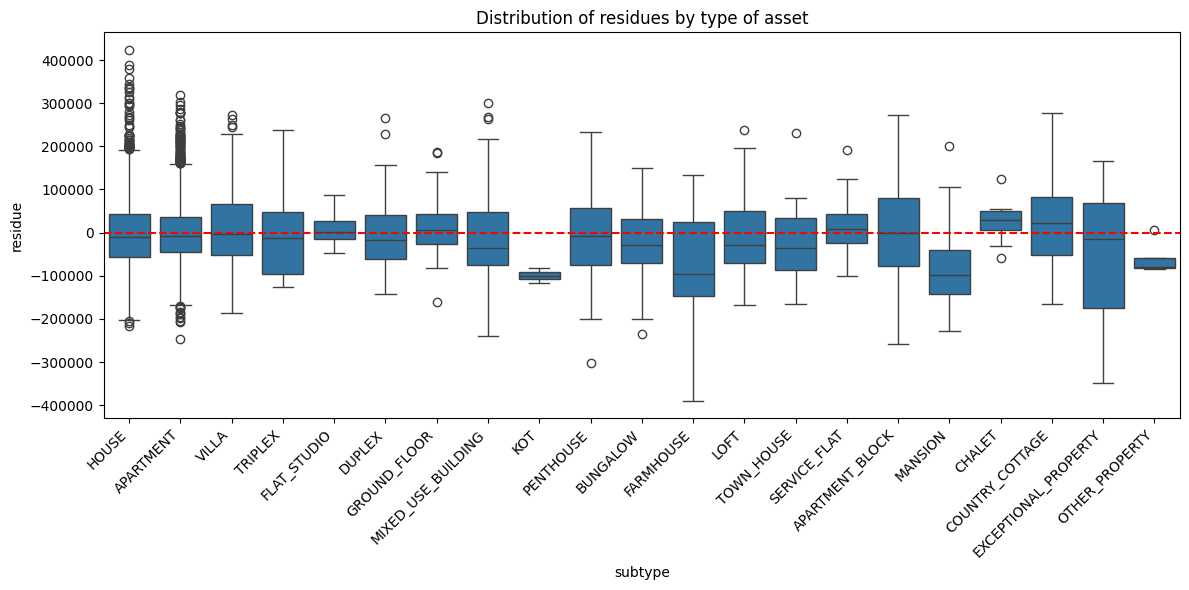

In [169]:
# Create the residuals column 
residus = y_test - y_pred_poly
df_residus = pd.DataFrame({
    "subtype": X_test["subtype"],  # Raw column (not encoded)
    "residue": residus
})

# We group all the present subtypes
plt.figure(figsize=(12, 6))
sns.boxplot(x="subtype", y="residue", data=df_residus)
plt.axhline(0, color="red", linestyle="--")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of residues by type of asset")
plt.tight_layout()
plt.show()

In [170]:
# Create a DataFrame with the residues and the subtype
df_residus = pd.DataFrame({
    "subtype": X_test["subtype"],
    "residue": y_test - y_pred_poly,
    "real_price": y_test,
    "predit_price": y_pred_poly
})

# Filter only the 'APARTMENT_BLOCK'
bloc_appart = df_residus[df_residus["subtype"] == "APARTMENT_BLOCK"]

# Descriptive statistics
print(bloc_appart["residue"].describe())

count        97.000000
mean      10429.225897
std      109848.441087
min     -257894.634661
25%      -76245.542141
50%         245.397849
75%       80963.807136
max      273252.707971
Name: residue, dtype: float64


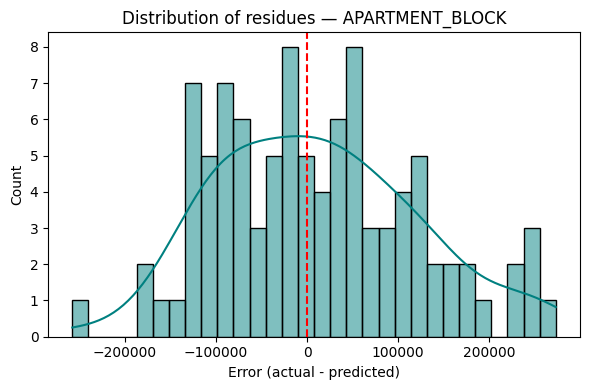

In [171]:
plt.figure(figsize=(6, 4))
sns.histplot(bloc_appart["residue"], bins=30, kde=True, color="teal")
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution of residues — APARTMENT_BLOCK")
plt.xlabel("Error (actual - predicted)")
plt.tight_layout()
plt.show()

In [172]:
# Filter only the properties of type "APARTMENT"
df_appart = df[df["type"] == "APARTMENT"].copy()

# Separate X and y
X_appt = df_appart.drop(columns=["price"])
y_appt = df_appart["price"]

In [ ]:
# Filter the apartments
df_appt = df[df["type"] == "APARTMENT"].copy()

# Keep the desired columns
cols_to_keep = ['subtype', 'bedroomCount', 'habitableSurface',
                'hasGarden', 'gardenSurface', 'hasTerrace', 'hasParking',
                'epc_score', 'building_condition']
X_appt = df_appt[cols_to_keep]
y_appt = df_appt["price"]

# Separation of columns
cat_features = ['subtype', 'epc_score', 'building_condition']
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore', drop='first'), cat_features)
], remainder="passthrough")

# 📦 Pipeline + split
model_appt = Pipeline([
    ("preprocessing", preprocessor),
    ("regression", LinearRegression())
])
X_train, X_test, y_train, y_test = train_test_split(X_appt, y_appt, test_size=0.8, random_state=42)

# Training
model_appt.fit(X_train, y_train)
y_pred = model_appt.predict(X_test)

# Assessment
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("R² of linear model on apartments :", r2)
print("MAE of linear model on apartments :", mae)
#print("RMSE :", rmse)

R² (linear model on apartments) : 0.47596864449061704
RMSE : 82563.70210705561


In [ ]:
# Log-transformer target
y_train_log = np.log1p(y_train)  # log(1 + y)
y_test_log = np.log1p(y_test)

# Pipeline regression log
log_model = make_pipeline(
    preprocessor,
    LinearRegression()
)

log_model.fit(X_train, y_train_log)
y_pred_log = log_model.predict(X_test)

# Reverse the transformation
y_pred_log_exp = np.expm1(y_pred_log)

# Assessment
#rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log_exp))
r2_log = r2_score(y_test, y_pred_log_exp)
mae = mean_absolute_error(y_test, y_pred_log_exp)

print("R² of log model :", r2_log)
print("MAE of log model :", mae)
#print("RMSE of log model :", rmse_log)

R² (log model) : 0.37981802147076127
MAE of log model : 63475.47829084751


In [175]:
# Selection of useful columns
cols_to_keep = ['subtype', 'bedroomCount', 'habitableSurface',
                'hasGarden', 'gardenSurface', 'hasTerrace', 'hasParking',
                'epc_score', 'building_condition']

df_appt = df[df["type"].str.upper() == "HOUSE"].copy()
X_appt = df_appt[cols_to_keep]
y_appt = df_appt["price"]

# Columns to process
poly_numeric = ['habitableSurface', 'bedroomCount']
cat_features = ['subtype', 'epc_score', 'building_condition']

# Combined preprocessor
preprocessor = ColumnTransformer([
    ("poly", PolynomialFeatures(degree=2, include_bias=False), poly_numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_features)
], remainder="passthrough")

# Pipeline
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("regression", LinearRegression())
])

# Split & fit
X_train, X_test, y_train, y_test = train_test_split(X_appt, y_appt, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Assessment
r2 = r2_score(y_test, y_pred)
#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("R² of Polynomial model on house :", r2)
print("MAE of Polynomial model on house :", mae)
#print("RMSE :", rmse)

R² of Polynomial model on house : 0.49418790257061473
MAE of Polynomial model on house : 79285.47710812786
